In [1]:
import findspark

In [2]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import  KMeans
from pyspark.sql import SQLContext
import pandas as pd
import glob
import yaml
import csv
import numpy as np

In [3]:
spark = SparkSession.builder.appName('data_analysis').getOrCreate()
df = spark.read .format("csv").option("header", "true").load("matches.csv")

In [4]:
from handyspark import *

In [5]:
hdf = df.toHandy()

In [6]:
df.fillna(0)

DataFrame[id: string, season: string, city: string, date: string, team1: string, team2: string, toss_winner: string, toss_decision: string, result: string, dl_applied: string, winner: string, win_by_runs: string, win_by_wickets: string, player_of_match: string, venue: string, umpire1: string, umpire2: string, umpire3: string]

In [7]:
df.filter("winner is null").count()

4

In [8]:
df = df.na.fill("Draw", "winner")

In [9]:
hdf = df.toHandy()

# Converting into a pandas data frame for further analysis

In [10]:
matches = df.toPandas()

In [11]:

import numpy as np
matches.replace(['Mumbai Indians','Kolkata Knight Riders','Royal Challengers Bangalore','Deccan Chargers','Chennai Super Kings',
                 'Rajasthan Royals','Delhi Daredevils','Gujarat Lions','Kings XI Punjab',
                 'Sunrisers Hyderabad','Rising Pune Supergiants','Kochi Tuskers Kerala','Pune Warriors','Rising Pune Supergiant']
                ,['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW','RPS'],inplace=True)

# number of matches played each season

In [12]:
sub_data1 = matches.iloc[:, 1]
season = sub_data1.value_counts().keys().tolist()
values = sub_data1.value_counts().tolist()
print(season, values)

['2013', '2012', '2011', '2016', '2019', '2018', '2010', '2014', '2015', '2017', '2008', '2009'] [76, 74, 73, 60, 60, 60, 60, 60, 59, 59, 58, 57]


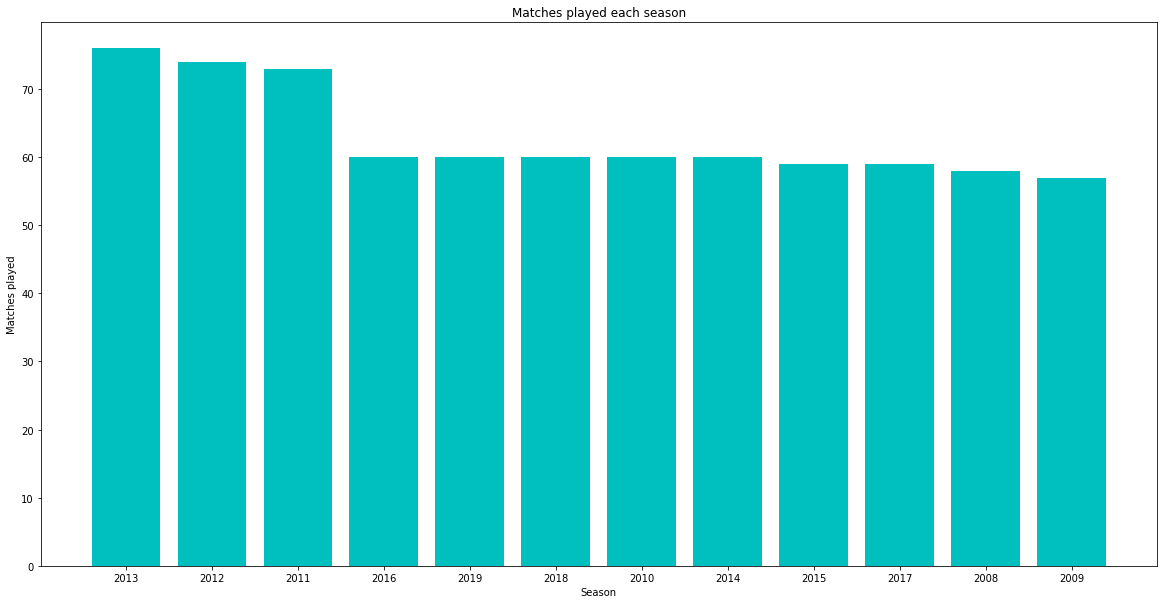

In [13]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(20,10)
plt.xlabel('Season')
plt.ylabel('Matches played')
plt.title('Matches played each season')
plt.bar(season, values, color = 'c')
plt.xticks(season)
plt.show()

# most player of match awards

In [14]:
df.createOrReplaceTempView("data")

In [15]:
most_player_awards=spark.sql("select distinct(player_of_match) as playerName,count(*) as number from data group by playerName order by number desc").collect()




# forming the list to pass in the matplotlib

In [16]:
players = []
numbers = []

for i in range(10):
    players.append(most_player_awards[i].playerName)
    numbers.append(most_player_awards[i].number)

In [17]:
most_player_awards[0].playerName

'CH Gayle'

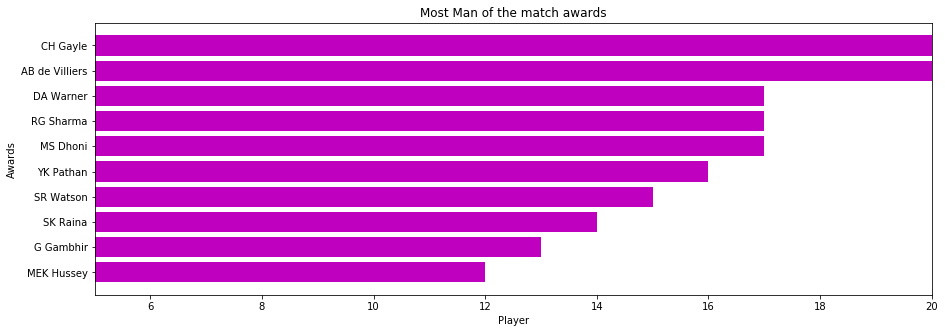

In [18]:

plt.gcf().set_size_inches(15,5)
plt.xlabel('Player')
plt.ylabel('Awards')
plt.title('Most Man of the match awards')
plt.barh(players,numbers, color = 'm', )
plt.gca().invert_yaxis()
plt.xlim(5, 20)
plt.show()

# relation between match win and toss win

In [19]:
toss_win=spark.sql("select count(*) as number from data where toss_winner = winner")




In [20]:
total=spark.sql("select count(*) as number from data")

In [21]:
toss_win.show()
total.show()

+------+
|number|
+------+
|   393|
+------+

+------+
|number|
+------+
|   756|
+------+



In [22]:
percentage = 325/636*100
print(percentage)

51.100628930817614


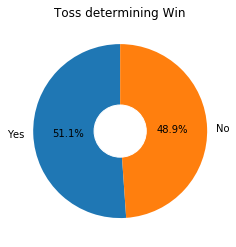

In [23]:

labels = ['Yes', 'No']
share = [percentage, 100 - percentage]
plt.pie(share, labels=labels,autopct='%1.1f%%', startangle=90)
plt.title('Toss determining Win')
my_circle=plt.Circle( (0,0), 0.3, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# the above chart breaks a myth that toss plays a major role in winning a match

# stadium wise breakdown of the matches played

In [24]:
most_matches_played=spark.sql("select distinct(city) as venue,count(*) as matchesPlayed from data group by data.city order by matchesPlayed desc").collect()




In [25]:
print(most_matches_played)

[Row(venue='Mumbai', matchesPlayed=101), Row(venue='Kolkata', matchesPlayed=77), Row(venue='Delhi', matchesPlayed=74), Row(venue='Bangalore', matchesPlayed=66), Row(venue='Hyderabad', matchesPlayed=64), Row(venue='Chennai', matchesPlayed=57), Row(venue='Jaipur', matchesPlayed=47), Row(venue='Chandigarh', matchesPlayed=46), Row(venue='Pune', matchesPlayed=38), Row(venue='Durban', matchesPlayed=15), Row(venue='Bengaluru', matchesPlayed=14), Row(venue='Visakhapatnam', matchesPlayed=13), Row(venue='Ahmedabad', matchesPlayed=12), Row(venue='Centurion', matchesPlayed=12), Row(venue='Mohali', matchesPlayed=10), Row(venue='Rajkot', matchesPlayed=10), Row(venue='Dharamsala', matchesPlayed=9), Row(venue='Indore', matchesPlayed=9), Row(venue='Johannesburg', matchesPlayed=8), Row(venue=None, matchesPlayed=7), Row(venue='Abu Dhabi', matchesPlayed=7), Row(venue='Cuttack', matchesPlayed=7), Row(venue='Port Elizabeth', matchesPlayed=7), Row(venue='Cape Town', matchesPlayed=7), Row(venue='Ranchi', matc

In [26]:
venue = []
macthesPlayed = []

for i in range(15):
    venue.append(most_matches_played[i].venue)
    macthesPlayed.append(most_matches_played[i].matchesPlayed)

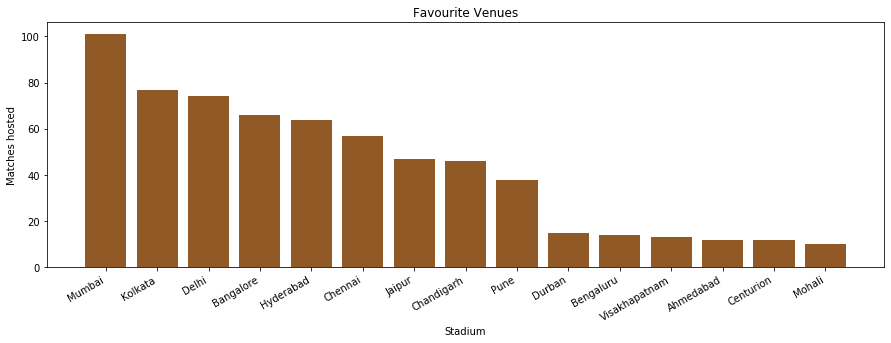

In [27]:
plt.gcf().set_size_inches(15,5)
plt.xlabel('Stadium')
plt.ylabel('Matches hosted')
plt.title('Favourite Venues')
plt.bar(venue,macthesPlayed , color = '#915925')
plt.gcf().autofmt_xdate()
plt.show()

# lets talk about the umpires, check who has done the most umpiring

In [28]:
umpire1=spark.sql("select distinct(umpire1) as umpire1,count(*) as counter1 from data group by data.umpire1 order by counter1 desc").collect()
umpire2=spark.sql("select distinct(umpire2) as umpire2,count(*) as counter2 from data group by data.umpire2 order by counter2 desc").collect()



In [29]:
name = []
count = []
for i in range(40):
    for j in range(40):
        
        if umpire1[i].umpire1 == umpire2[j].umpire2:
            count.append(umpire1[i].counter1 + umpire2[i].counter2)
            name.append(umpire1[i].umpire1)
    

In [30]:
print(name)

['HDPK Dharmasena', 'S Ravi', 'AK Chaudhary', 'BR Doctrove', 'M Erasmus', 'RE Koertzen', 'Nitin Menon', 'S Asnani', 'C Shamshuddin', 'CB Gaffaney', 'NJ Llong', 'RK Illingworth', 'SS Hazare', 'VA Kulkarni', 'S Das', 'K Hariharan', 'Anil Chaudhary', 'DJ Harper', 'BNJ Oxenford', 'IL Howell', 'O Nandan', 'CK Nandan']


In [31]:
print (count)

[130, 103, 81, 62, 58, 45, 43, 41, 37, 32, 25, 22, 22, 21, 19, 19, 18, 17, 13, 13, 12, 10]


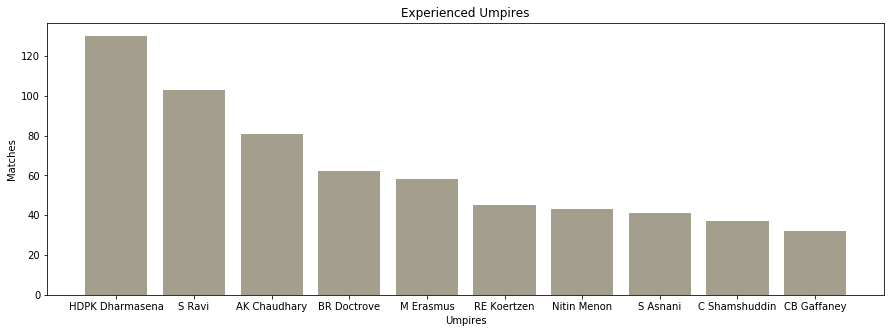

In [32]:
plt.gcf().set_size_inches(15,5)
plt.xlabel('Umpires')
plt.ylabel('Matches')
plt.title('Experienced Umpires')
plt.bar(name[0:10], count[0:10], color = '#A49F8C')
plt.show()

# lets check the matches won by each team and plot it

In [33]:
from collections import Counter
teams = matches.loc[:, ['team1', 'team2', 'winner']]
team1 = teams['team1'].tolist()
team2 = teams['team2'].tolist()
teamsCount = team1 + team2
c = Counter(teamsCount)
teams1 = []
matches1 = []
for i,j in c.most_common():
    teams1.append(i)
    matches1.append(j)
wins = matches['winner'].value_counts().tolist()
print(teams1, matches1, wins)
loss = [int(n1) - int(n2) for n1,n2 in zip(matches1, wins)]
print(loss)
wins = wins[0:14]

['MI', 'RCB', 'KKR', 'KXIP', 'CSK', 'DD', 'RR', 'SRH', 'DC', 'PW', 'GL', 'RPS', 'Delhi Capitals', 'KTK'] [187, 180, 178, 176, 164, 161, 147, 108, 75, 46, 30, 30, 16, 14] [109, 100, 92, 84, 82, 75, 67, 58, 29, 15, 13, 12, 10, 6, 4]
[78, 80, 86, 92, 82, 86, 80, 50, 46, 31, 17, 18, 6, 8]


In [34]:
print(wins)

[109, 100, 92, 84, 82, 75, 67, 58, 29, 15, 13, 12, 10, 6]


[187, 180, 178, 176, 164, 161, 147, 108, 75, 46, 30, 30, 16, 14]
[109, 100, 92, 84, 82, 75, 67, 58, 29, 15, 13, 12, 10, 6]


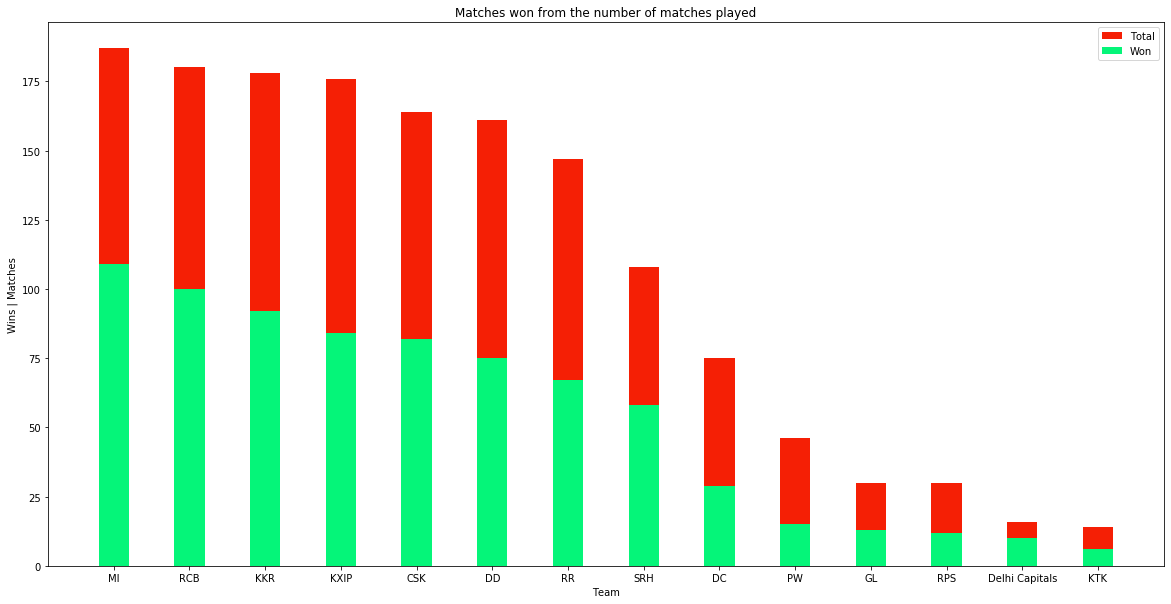

In [35]:

plt.gcf().set_size_inches(20,10)
plt.xlabel('Team')
plt.ylabel('Wins | Matches')
plt.title('Matches won from the number of matches played')
def subcategorybar(X, vals, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    plt.bar(_X, vals[0], width=width/n, color = '#F51F05')
    print(vals[0])
    print(vals[1])
    plt.bar(_X, vals[1], width=width/n, color = '#05F579')
    plt.xticks(_X, X)

subcategorybar(teams1, [matches1, wins])
label = ['Total', 'Won']
plt.legend(labels = label)
plt.show()

# Now lets analyse the deliveries data set

In [36]:
deliveries = spark.read .format("csv").option("header", "true").load("deliveries.csv")

In [37]:
deliveries.show(5)

+--------+------+-------------------+--------------------+----+----+---------+-----------+--------+-------------+---------+--------+-----------+-----------+------------+------------+----------+----------+----------------+--------------+-------+
|match_id|inning|       batting_team|        bowling_team|over|ball|  batsman|non_striker|  bowler|is_super_over|wide_runs|bye_runs|legbye_runs|noball_runs|penalty_runs|batsman_runs|extra_runs|total_runs|player_dismissed|dismissal_kind|fielder|
+--------+------+-------------------+--------------------+----+----+---------+-----------+--------+-------------+---------+--------+-----------+-----------+------------+------------+----------+----------+----------------+--------------+-------+
|       1|     1|Sunrisers Hyderabad|Royal Challengers...|   1|   1|DA Warner|   S Dhawan|TS Mills|            0|        0|       0|          0|          0|           0|           0|         0|         0|            null|          null|   null|
|       1|     1|Sun

In [38]:
deliveries.createOrReplaceTempView("delivery")

In [39]:
df_select=df.distinct().select('id','season')

In [40]:
df_select.show(5)

+---+------+
| id|season|
+---+------+
| 84|  2008|
|561|  2015|
|566|  2015|
|571|  2015|
|376|  2012|
+---+------+
only showing top 5 rows



In [41]:
deliveries=deliveries.withColumnRenamed("match_id","id")

In [42]:
df_joined = deliveries.join(df_select, 'id')

In [43]:
df_joined.createOrReplaceTempView("joined")

# lets find out the scores across seasons

In [44]:
runs_scored=spark.sql("select distinct(season) as season,sum(total_runs) as total_runs from joined group by season order by season").collect()


In [45]:
runs = []
season = []

for i in range(12):
    runs.append(runs_scored[i].total_runs)
    season.append(runs_scored[i].season)

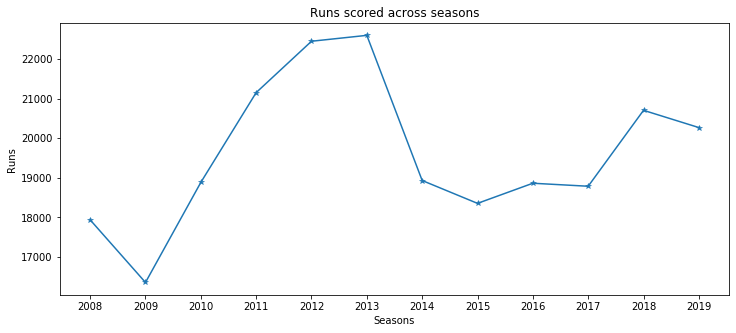

In [46]:

plt.gcf().set_size_inches(12, 5)
plt.xlabel('Seasons')
plt.ylabel('Runs')
plt.title('Runs scored across seasons')
plt.plot(season, runs, marker='*')
plt.xticks(season)
plt.show()

# we see that in the middle seasons number of runs scored is much more than earlier and later seasons.. 

# lets try to findout highest wicket takers in the league

In [48]:
wickets=spark.sql("select bowler,batsman,dismissal_kind from delivery where dismissal_kind is not null group by bowler,batsman,dismissal_kind")




In [49]:
wickets.filter("dismissal_kind is null").count()

0

In [50]:
from pyspark.sql.functions import *

In [51]:
wickets = wickets.withColumn('dismissal_kind', regexp_replace('dismissal_kind', 'caught and bowled', 'c'))

In [52]:
wickets = wickets.withColumn('dismissal_kind', regexp_replace('dismissal_kind', 'caught', 'c'))

In [53]:
wickets = wickets.withColumn('dismissal_kind', regexp_replace('dismissal_kind', 'run out', 'c'))
wickets = wickets.withColumn('dismissal_kind', regexp_replace('dismissal_kind', 'bowled', 'c'))
wickets = wickets.withColumn('dismissal_kind', regexp_replace('dismissal_kind', 'hit wicket', 'c'))
wickets = wickets.withColumn('dismissal_kind', regexp_replace('dismissal_kind', 'lbw', 'c'))
wickets = wickets.withColumn('dismissal_kind', regexp_replace('dismissal_kind', 'stumped', 'c'))



In [54]:
wickets.show(20)

+---------------+---------------+--------------+
|         bowler|        batsman|dismissal_kind|
+---------------+---------------+--------------+
|     SL Malinga|      V Shankar|             c|
|      JJ Bumrah|        RR Pant|             c|
|NM Coulter-Nile|        SS Iyer|             c|
|       SK Warne|       SB Joshi|             c|
|      IK Pathan|        V Kohli|             c|
|Y Venugopal Rao|     RV Uthappa|             c|
|     SL Malinga|    LRPL Taylor|             c|
|       A Mishra|  Yashpal Singh|             c|
|      DP Nannes|     SC Ganguly|             c|
|        A Nehra|Y Venugopal Rao|             c|
|     SL Malinga|       PA Patel|             c|
| M Muralitharan|     SC Ganguly|             c|
|      DP Nannes|    SA Asnodkar|             c|
|       UT Yadav|      DJ Hussey|             c|
|         Z Khan|       AC Voges|             c|
|        PP Ojha|       SK Raina|             c|
|       BA Bhatt|Harbhajan Singh|             c|
|     SL Malinga|   

In [55]:
wickets.createOrReplaceTempView("wickets")

In [56]:
wickets_count=spark.sql("select distinct(bowler),count(*) as wickets_count from wickets group by bowler,dismissal_kind order by wickets_count desc").collect()




In [57]:
print(wickets_count[0:5])

[Row(bowler='SL Malinga', wickets_count=158), Row(bowler='A Mishra', wickets_count=139), Row(bowler='Harbhajan Singh', wickets_count=136), Row(bowler='PP Chawla', wickets_count=134), Row(bowler='DJ Bravo', wickets_count=133)]


In [58]:
wickets = []
bowler = []

for i in range(10):
    wickets.append(wickets_count[i].wickets_count)
    bowler.append(wickets_count[i].bowler)

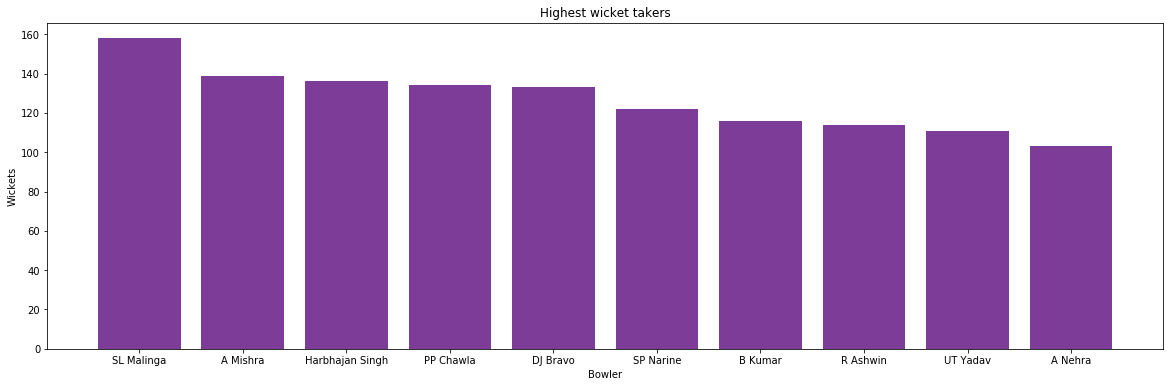

In [59]:

plt.gcf().set_size_inches(20,6)
plt.xlabel('Bowler')
plt.ylabel('Wickets')
plt.title('Highest wicket takers')
plt.bar(bowler, wickets, color = '#7D3C98')
plt.show()

# lets try to find the count for each dismissal type

In [60]:
dismissal_count=spark.sql("select distinct(dismissal_kind), count(*) as counter from delivery where dismissal_kind is not null group by dismissal_kind order by counter desc").collect()


In [61]:
count = []
dismissal = []

for i in range(7):
    count.append(dismissal_count[i].counter)
    dismissal.append(dismissal_count[i].dismissal_kind)

In [62]:
dictionary = [[x,y] for x,y in zip(dismissal, count)]
print(dictionary)

[['caught', 5348], ['bowled', 1581], ['run out', 852], ['lbw', 540], ['stumped', 278], ['caught and bowled', 211], ['retired hurt', 12]]


/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Unrecognized location 'left center'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


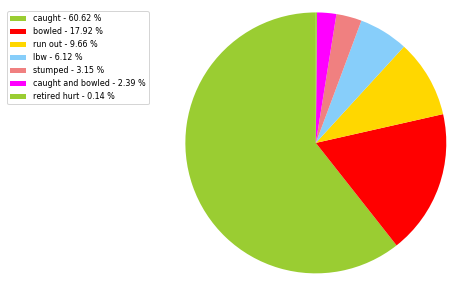

In [63]:

labels = [i for i in dismissal]
explode = (0.1, 0, 0, 0, 0, 0)

x = np.char.array(dismissal)
y = np.array(count)
colors = ['yellowgreen','red','gold','lightskyblue','lightcoral','magenta']
porcent = 100.*y/y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))
plt.gcf().set_size_inches(10,5)
plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.show()

# we can see that since ipl is a fast paced tournament with 20-20 format most of the dismissals are caught

In [64]:
deliveries.show(5)

+---+------+-------------------+--------------------+----+----+---------+-----------+--------+-------------+---------+--------+-----------+-----------+------------+------------+----------+----------+----------------+--------------+-------+
| id|inning|       batting_team|        bowling_team|over|ball|  batsman|non_striker|  bowler|is_super_over|wide_runs|bye_runs|legbye_runs|noball_runs|penalty_runs|batsman_runs|extra_runs|total_runs|player_dismissed|dismissal_kind|fielder|
+---+------+-------------------+--------------------+----+----+---------+-----------+--------+-------------+---------+--------+-----------+-----------+------------+------------+----------+----------+----------------+--------------+-------+
|  1|     1|Sunrisers Hyderabad|Royal Challengers...|   1|   1|DA Warner|   S Dhawan|TS Mills|            0|        0|       0|          0|          0|           0|           0|         0|         0|            null|          null|   null|
|  1|     1|Sunrisers Hyderabad|Royal Ch

In [65]:
df_new = deliveries.toPandas()

In [66]:
df_new.head()

,id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,None,None,None
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,None,None,None
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,None,None,None
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,None,None,None
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,None,None,None


# analysis top 3 run scorers and how they score most of their runs

In [102]:
top_batsman = df_new.loc[:, ['batsman', 'batsman_runs']]
is_raina = top_batsman['batsman'] == 'SK Raina'
raina_data = top_batsman[is_raina]
raina_all = raina_data.shape[0]
#print (raina_data)
#print (raina_data['batsman_runs'] != 1)
is_0 = raina_data['batsman_runs'] == '0'
#print (is_0)
is_1 = raina_data['batsman_runs'] == '1'
is_2 = raina_data['batsman_runs'] == '2'
is_3 = raina_data['batsman_runs'] == '3'
is_4 = (raina_data['batsman_runs'] == '4') | (raina_data['batsman_runs'] == '5')
#print (is_1)
is_6 = raina_data['batsman_runs'] == '6'
raina_0 = raina_data[is_0]
#print (raina_0.shape[0])
raina_0 = raina_0.shape[0]
raina_1 = raina_data[is_1]
raina_1 = raina_1.shape[0]
raina_2 = raina_data[is_2]
raina_2 = raina_2.shape[0]
raina_3 = raina_data[is_3]
raina_3 = raina_3.shape[0]
raina_4 = raina_data[is_4]
raina_4 = raina_4.shape[0]
raina_6 = raina_data[is_6]
raina_6 = raina_6.shape[0]

In [103]:
labels1 = '0s', '1s', '2s', '3s', '4s', '6s'
sizes1 = [raina_0, raina_1, raina_2, raina_3, raina_4, raina_6]
explode = (0, 0, 0, 0, 0, 0.1)

In [105]:
is_kohli = top_batsman['batsman'] == 'V Kohli'
kohli_data = top_batsman[is_kohli]
kohli_all = kohli_data.shape[0]
is_0 = kohli_data['batsman_runs'] == '0'
is_1 = kohli_data['batsman_runs'] == '1'
is_2 = kohli_data['batsman_runs'] == '2'
is_3 = kohli_data['batsman_runs'] == '3'
is_4 = (kohli_data['batsman_runs'] == '4') | (kohli_data['batsman_runs'] == '5')
is_6 = kohli_data['batsman_runs'] == '6'
kohli_0 = kohli_data[is_0]
kohli_0 = kohli_0.shape[0]
kohli_1 = kohli_data[is_1]
kohli_1 = kohli_1.shape[0]
kohli_2 = kohli_data[is_2]
kohli_2 = kohli_2.shape[0]
kohli_3 = kohli_data[is_3]
kohli_3 = kohli_3.shape[0]
kohli_4 = kohli_data[is_4]
kohli_4 = kohli_4.shape[0]
kohli_6 = kohli_data[is_6]
kohli_6 = kohli_6.shape[0]

In [106]:
labels2 = '0s', '1s', '2s', '3s', '4s', '6s'
sizes2 = [kohli_0, kohli_1, kohli_2, kohli_3, kohli_4, kohli_6]
explode = (0, 0, 0, 0, 0, 0.1)

In [108]:
is_sharma = top_batsman['batsman'] == 'RG Sharma'
sharma_data = top_batsman[is_sharma]
sharma_all = sharma_data.shape[0]
is_0 = sharma_data['batsman_runs'] == '0'
is_1 = sharma_data['batsman_runs'] == '1'
is_2 = sharma_data['batsman_runs'] == '2'
is_3 = sharma_data['batsman_runs'] == '3'
is_4 = (sharma_data['batsman_runs'] == '4') | (sharma_data['batsman_runs'] == '5')
is_6 = sharma_data['batsman_runs'] == '6'
sharma_0 = sharma_data[is_0]
sharma_0 = sharma_0.shape[0]
sharma_1 = sharma_data[is_1]
sharma_1 = sharma_1.shape[0]
sharma_2 = sharma_data[is_2]
sharma_2 = sharma_2.shape[0]
sharma_3 = sharma_data[is_3]
sharma_3 = sharma_3.shape[0]
sharma_4 = sharma_data[is_4]
sharma_4 = sharma_4.shape[0]
sharma_6 = sharma_data[is_6]
sharma_6 = sharma_6.shape[0]

In [109]:

labels3 = '0s', '1s', '2s', '3s', '4s', '6s'
sizes3 = [sharma_0, sharma_1, sharma_2, sharma_3, sharma_4, sharma_6]
explode = (0, 0, 0, 0, 0, 0.1)

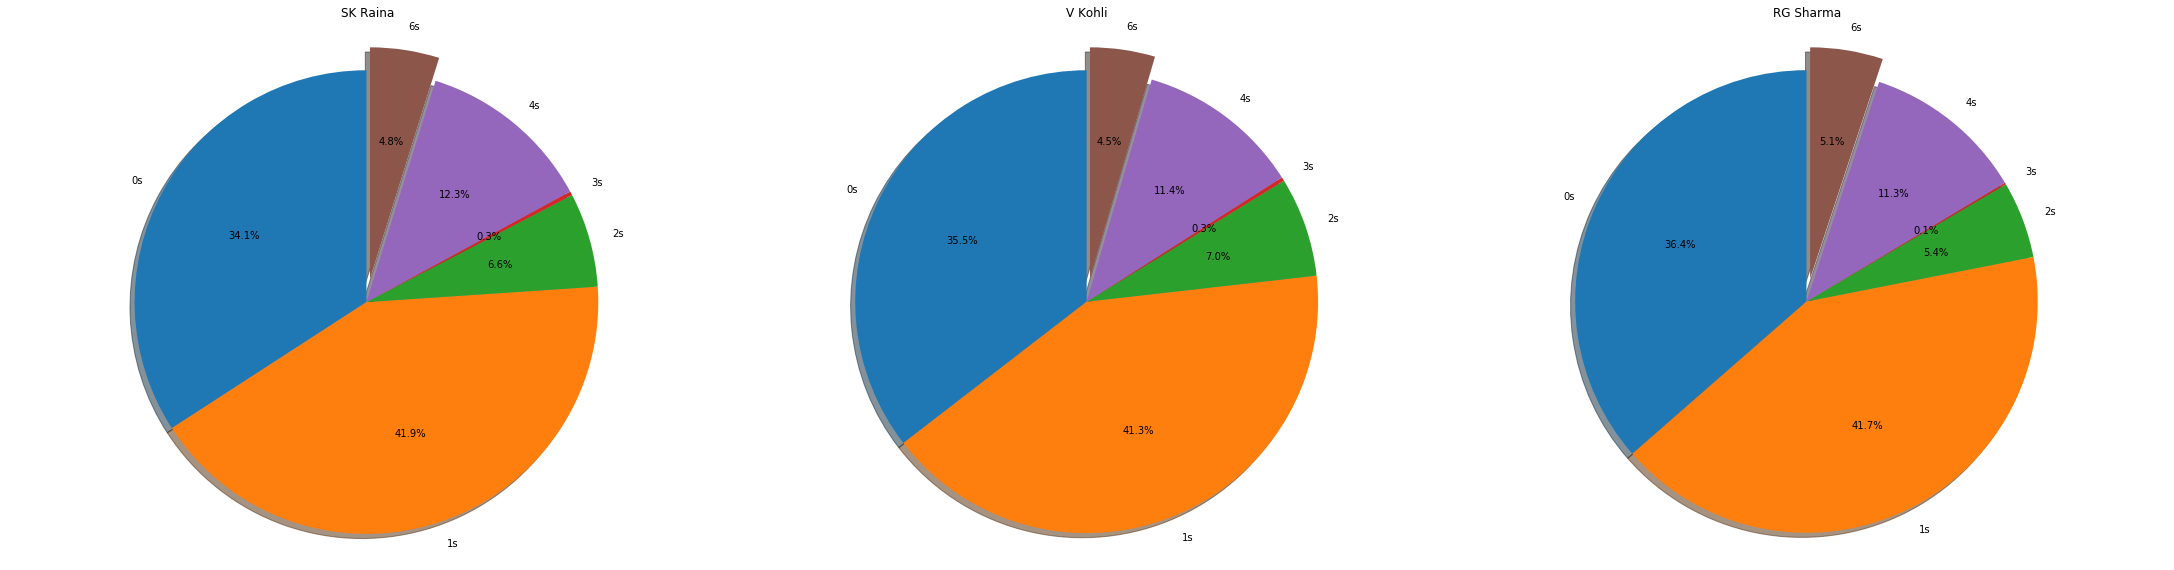

SK Raina
('0s', '1s', '2s', '3s', '4s', '6s') [1381, 1695, 266, 11, 496, 195]
Virat kohli
('0s', '1s', '2s', '3s', '4s', '6s') [1493, 1741, 293, 11, 482, 191]
Rohit Sharma
('0s', '1s', '2s', '3s', '4s', '6s') [1390, 1589, 205, 5, 432, 194]


In [111]:
fig = plt.figure()
ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(sizes1, explode=explode, labels=labels1, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('SK Raina')

ax2 = fig.add_axes([.5, 0, .5, .5], aspect=1)
ax2.pie(sizes2, explode=explode, labels=labels2, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('V Kohli')

ax3 = fig.add_axes([1, 0, .5, .5], aspect=1)
ax3.pie(sizes3, explode=explode, labels=labels3, autopct='%1.1f%%', shadow=True, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax3.set_title('RG Sharma')
plt.gcf().set_size_inches(20,15)
plt.show()
print ('SK Raina')
print(labels1, sizes1)
print ('Virat kohli')
print(labels2, sizes2)
print ('Rohit Sharma')
print(labels3, sizes3)